# Evaluation 2DoF Point Robot

In this notebook we will evaluate the extended A* using a point robot in a 2 DoF environment. First let us take a look at the environments used for evaluation:

In [ ]:
from core.IPBenchmark import Benchmark 
import evaluation.two_dof.IPTestSuite_2DoF as ts
import matplotlib.pyplot as plt

from evaluation.two_dof.PlotEnvironments import visualizeBenchmark

#because of time constraints we use a selection of benchmarks instead of the whole list.
evaluation_indices = [0, 1, 2, 3, 6]

for benchmark in [ts.benchList[i] for i in evaluation_indices]:
        benchmark: Benchmark
        print(f"----- benchmark: {benchmark.name} -----")
        fig, ax = visualizeBenchmark(benchmark)
        plt.show()

## Evaluation Code

In this section you can find some code for evaluating A*, loading existing results and plotting the results.

In [ ]:
import os
import json
import networkx as nx
from typing import List, Dict

import sys
import os

sys.path.append(os.path.join(os.getcwd(), 'core'))
sys.path.append(os.path.join(os.getcwd(), 'evaluation/two_dof'))

from core.IPAStarExtended import AStar
from Benchmarking import get_config_dir_name, evaluate

def get_evaluation_results(configs: List[Dict], dump: bool = True):
    results = []
    for i, config in enumerate(configs):
        print(f"----- config {i + 1} of {len(configs)} -----")

        config_results = {}
        benchmarks = [ts.benchList[i] for i in config["benchmarks"]]

        for benchmark in benchmarks:
            print(f"----- benchmark: {benchmark.name} -----")
            benchmark_results = {}

            dir_name = get_config_dir_name(config=config, benchmark_name=benchmark.name)

            if os.path.exists(dir_name):
                # load evaluation results if they exist.

                astar = AStar(benchmark.collisionChecker)
                astar.start = benchmark.startList[0]
                astar.goal = benchmark.goalList[0]

                with open(f'{dir_name}/stats.json') as f:
                    stats = json.load(f)

                with open(f'{dir_name}/solution.json') as f:
                    solution = json.load(f)

                with open(f'{dir_name}/deltas.json') as f:
                    deltas = json.load(f)

                with open(f'{dir_name}/graph.json') as f:
                    graph = nx.node_link_graph(json.load(f))
                    astar.graph = graph 

            else:
                # do evaluation

                stats, solution, deltas, astar = evaluate(config=config, benchmark=benchmark, dump=dump)

            
            benchmark_results["stats"] = stats
            benchmark_results["solution"] = solution
            benchmark_results["deltas"] = deltas
            benchmark_results["astar"] = astar

            config_results[benchmark.name] = benchmark_results
        results.append((config, config_results))
    return results    





In [ ]:
def plot_results_line(results: List, x_axis_values: List, x_axis_title: str):
    # plot execution time
    plot_lines = {}
    for bench_name in results[0][1].keys():
        plot_lines[bench_name] = []

    for _, config_results in results:
        for bench_name, benchmark_results in config_results.items():
            plot_lines[bench_name].append(benchmark_results["stats"]["execution_time"])

    for bench_name in results[0][1].keys():
        plt.plot(x_axis_values, plot_lines[bench_name], "o-", label = bench_name)
    plt.legend()
    plt.title("Execution Time")
    plt.xlabel(x_axis_title)
    plt.ylabel("Execution Time [s]")
    plt.show()

    # plot roadmap size
    plot_lines = {}
    for bench_name in results[0][1].keys():
        plot_lines[bench_name] = []

    for _, config_results in results:
        for bench_name, benchmark_results in config_results.items():
            plot_lines[bench_name].append(benchmark_results["stats"]["road_map_size"])

    for bench_name in results[0][1].keys():
        plt.plot(x_axis_values, plot_lines[bench_name], "o-", label = bench_name)
    plt.legend()
    plt.title("Roadmap Size")
    plt.xlabel(x_axis_title)
    plt.ylabel("Roadmap Size")
    plt.show()

    # plot nume nodes in solution path
    plot_lines = {}
    for bench_name in results[0][1].keys():
        plot_lines[bench_name] = []

    for _, config_results in results:
        for bench_name, benchmark_results in config_results.items():
            if (benchmark_results["stats"]["num_nodes_solution_path"] >= 0):
                plot_lines[bench_name].append(benchmark_results["stats"]["num_nodes_solution_path"])
            else:
                plot_lines[bench_name].append(np.nan)

    for bench_name in results[0][1].keys():
        plt.plot(x_axis_values, plot_lines[bench_name], "o-", label = bench_name)
    plt.legend()
    plt.title("Number of Nodes in Solution Path")
    plt.xlabel(x_axis_title)
    plt.ylabel("Number of Nodes in Solution Path")
    plt.show()

    # plot solution path length
    plot_lines = {}
    for bench_name in results[0][1].keys():
        plot_lines[bench_name] = []

    for _, config_results in results:
        for bench_name, benchmark_results in config_results.items():
            if (benchmark_results["stats"]["solution_path_length"] >= 0):
                plot_lines[bench_name].append(benchmark_results["stats"]["solution_path_length"])
            else:
                plot_lines[bench_name].append(np.nan)

    for bench_name in results[0][1].keys():
        plt.plot(x_axis_values, plot_lines[bench_name], "o-", label = bench_name)
    plt.legend()
    plt.title("Solution Path Length")
    plt.xlabel(x_axis_title)
    plt.ylabel("Solution Path Length")
    plt.show()

In [ ]:
def plot_results_bar(results: List, x_axis_values: List, x_axis_title: str):
    # plot execution time
    plot_lines = {}
    for bench_name in results[0][1].keys():
        plot_lines[bench_name] = []

    for _, config_results in results:
        for bench_name, benchmark_results in config_results.items():
            plot_lines[bench_name].append(benchmark_results["stats"]["execution_time"])

    for bench_name in results[0][1].keys():
        plt.bar(x_axis_values, plot_lines[bench_name], label = bench_name)
    plt.legend()
    plt.title("Execution Time")
    plt.xlabel(x_axis_title)
    plt.ylabel("Execution Time [s]")
    plt.show()

    # plot roadmap size
    plot_lines = {}
    for bench_name in results[0][1].keys():
        plot_lines[bench_name] = []

    for _, config_results in results:
        for bench_name, benchmark_results in config_results.items():
            plot_lines[bench_name].append(benchmark_results["stats"]["road_map_size"])

    for bench_name in results[0][1].keys():
        plt.bar(x_axis_values, plot_lines[bench_name], label = bench_name)
    plt.legend()
    plt.title("Roadmap Size")
    plt.xlabel(x_axis_title)
    plt.ylabel("Roadmap Size")
    plt.show()

    # plot nume nodes in solution path
    plot_lines = {}
    for bench_name in results[0][1].keys():
        plot_lines[bench_name] = []

    for _, config_results in results:
        for bench_name, benchmark_results in config_results.items():
            if (benchmark_results["stats"]["num_nodes_solution_path"] >= 0):
                plot_lines[bench_name].append(benchmark_results["stats"]["num_nodes_solution_path"])
            else:
                plot_lines[bench_name].append(np.nan)

    for bench_name in results[0][1].keys():
        plt.bar(x_axis_values, plot_lines[bench_name], label = bench_name)
    plt.legend()
    plt.title("Number of Nodes in Solution Path")
    plt.xlabel(x_axis_title)
    plt.ylabel("Number of Nodes in Solution Path")
    plt.show()

    # plot solution path length
    plot_lines = {}
    for bench_name in results[0][1].keys():
        plot_lines[bench_name] = []

    for _, config_results in results:
        for bench_name, benchmark_results in config_results.items():
            if (benchmark_results["stats"]["solution_path_length"] >= 0):
                plot_lines[bench_name].append(benchmark_results["stats"]["solution_path_length"])
            else:
                plot_lines[bench_name].append(np.nan)

    for bench_name in results[0][1].keys():
        plt.bar(x_axis_values, plot_lines[bench_name], label = bench_name)
    plt.legend()
    plt.title("Solution Path Length")
    plt.xlabel(x_axis_title)
    plt.ylabel("Solution Path Length")
    plt.show()

## Evaluation: Discretization

In this section we will evaluate the influence of the discretization on A*

In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np

disc_values = [10, 20, 50, 100, 200]

configs = []

discretization_config = dict()
discretization_config["w"] = 0.5
discretization_config["heuristic"]  = "euclidean"
discretization_config["reopen"] = True
discretization_config["dof"] = 2
discretization_config["check_connection"] = True
discretization_config["lazy_check_connection"] = True
discretization_config["benchmarks"] = [0, 1, 2, 3, 6]

for discretization_value in disc_values:
    config = copy.deepcopy(discretization_config)
    config["discretization"] = [discretization_value for _ in range(config["dof"])]
    configs.append(config)

results = get_evaluation_results(configs=configs)

plot_results_line(results=results, x_axis_values=disc_values, x_axis_title="Discretization Steps")

In [ ]:
# show results

from IPVISAStar import aStarVisualize

for i, (_, config_results) in enumerate(results):
    fig = plt.figure(figsize=(35,10))
    for j, (bench_name, benchmark_results) in enumerate(config_results.items()):
        astar = benchmark_results["astar"]
        solution = benchmark_results["solution"]
        ax = fig.add_subplot(1,len(config_results.items()),j + 1)
        aStarVisualize(planner=astar, solution=solution, ax=ax, nodeSize=(1000 / disc_values[i]), viz_solution=(len(solution) > 0))
    fig.suptitle(f"Discretization: {disc_values[i]}", fontsize=50)
    plt.show()

## Evaluation: Weight w

In this section we will evaluate the influence of the weight w

In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np

w_values = [0.5, 0.75, 1.0]

configs = []

weight_config = dict()
weight_config["heuristic"] = "euclidean"
weight_config["reopen"] = True
weight_config["dof"] = 2
weight_config["discretization"] = [50 for _ in range(weight_config["dof"])]
weight_config["check_connection"] = True
weight_config["lazy_check_connection"] = True
weight_config["benchmarks"] = [0, 1, 2, 3, 6]

for w_value in w_values:
    config = copy.deepcopy(weight_config)
    config["w"] = w_value
    configs.append(config)

results = get_evaluation_results(configs=configs)

plot_results_line(results=results, x_axis_values=w_values, x_axis_title="Weight w")

In [ ]:
# show results

from IPVISAStar import aStarVisualize

for i, (_, config_results) in enumerate(results):
    fig = plt.figure(figsize=(35,10))
    for j, (bench_name, benchmark_results) in enumerate(config_results.items()):
        astar = benchmark_results["astar"]
        solution = benchmark_results["solution"]
        ax = fig.add_subplot(1,len(config_results.items()),j + 1)
        aStarVisualize(planner=astar, solution=solution, ax=ax, nodeSize=(1000 / disc_values[i]), viz_solution=(len(solution) > 0))
    fig.suptitle(f"Weight: {w_values[i]}", fontsize=50)
    plt.show()

## Evaluation: Line Collision

In this section we will evaluate the influence of line collision detection

----- config 1 of 2 -----
----- benchmark: Big_Blocks -----
----- benchmark: Filters -----
----- benchmark: Bubble_Bath -----
----- benchmark: Mikado -----
----- benchmark: Maze -----
----- config 2 of 2 -----
----- benchmark: Big_Blocks -----
----- benchmark: Filters -----
----- benchmark: Bubble_Bath -----
----- benchmark: Mikado -----
----- benchmark: Maze -----


/home/simon/miniconda3/envs/ir/lib/python3.13/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


ConversionError: Failed to convert value(s) to axis units: 'o-'

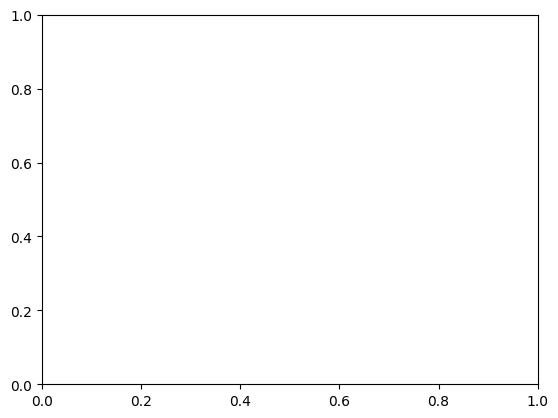

In [16]:
import copy
import matplotlib.pyplot as plt
import numpy as np

w_values = [0.5, 0.75, 1.0]

configs = []

line_coll_config = dict()
line_coll_config["heuristic"] = "euclidean"
line_coll_config["reopen"] = True
line_coll_config["dof"] = 2
line_coll_config["discretization"] = [50 for _ in range(line_coll_config["dof"])]
line_coll_config["w"] = .5
line_coll_config["benchmarks"] = [0, 1, 2, 3, 6]

config = copy.deepcopy(line_coll_config)
config["check_connection"] = True
config["lazy_check_connection"] = True
configs.append(config)

config = copy.deepcopy(line_coll_config)
config["check_connection"] = False
config["lazy_check_connection"] = False
configs.append(config)

results = get_evaluation_results(configs=configs)

plot_results_bar(results=results, x_axis_values=[True, False], x_axis_title="Line Collision Activated?")

Drawing graph took 0.9054 seconds
Drawing obstacles took 0.0033 seconds
Drawing graph took 1.2480 seconds
Drawing obstacles took 0.0228 seconds
Drawing graph took 1.7019 seconds
Drawing obstacles took 0.1065 seconds
Drawing graph took 1.6304 seconds
Drawing obstacles took 0.1449 seconds
Drawing graph took 1.1797 seconds
Drawing obstacles took 0.0507 seconds


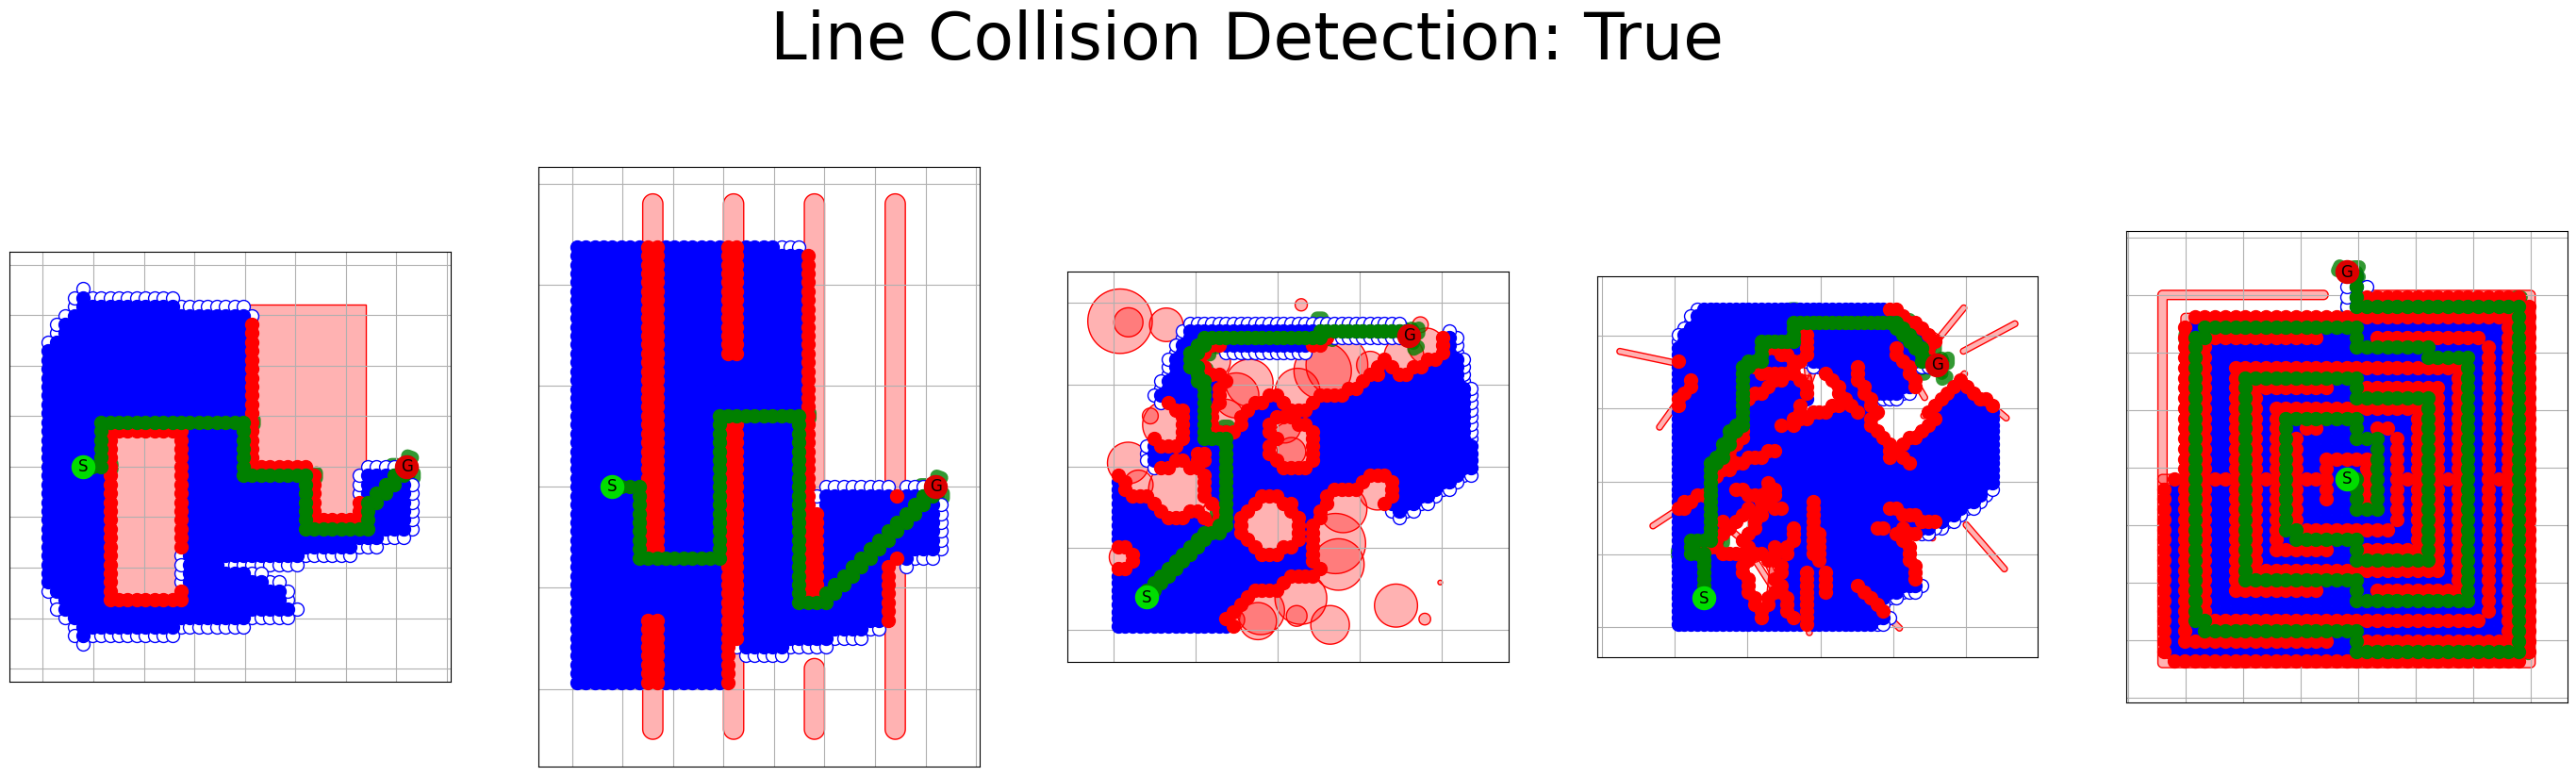

Drawing graph took 0.8797 seconds
Drawing obstacles took 0.0039 seconds
Drawing graph took 1.2372 seconds
Drawing obstacles took 0.0231 seconds
Drawing graph took 1.9223 seconds
Drawing obstacles took 0.1029 seconds
Drawing graph took 1.6650 seconds
Drawing obstacles took 0.1324 seconds
Drawing graph took 1.1784 seconds
Drawing obstacles took 0.0477 seconds


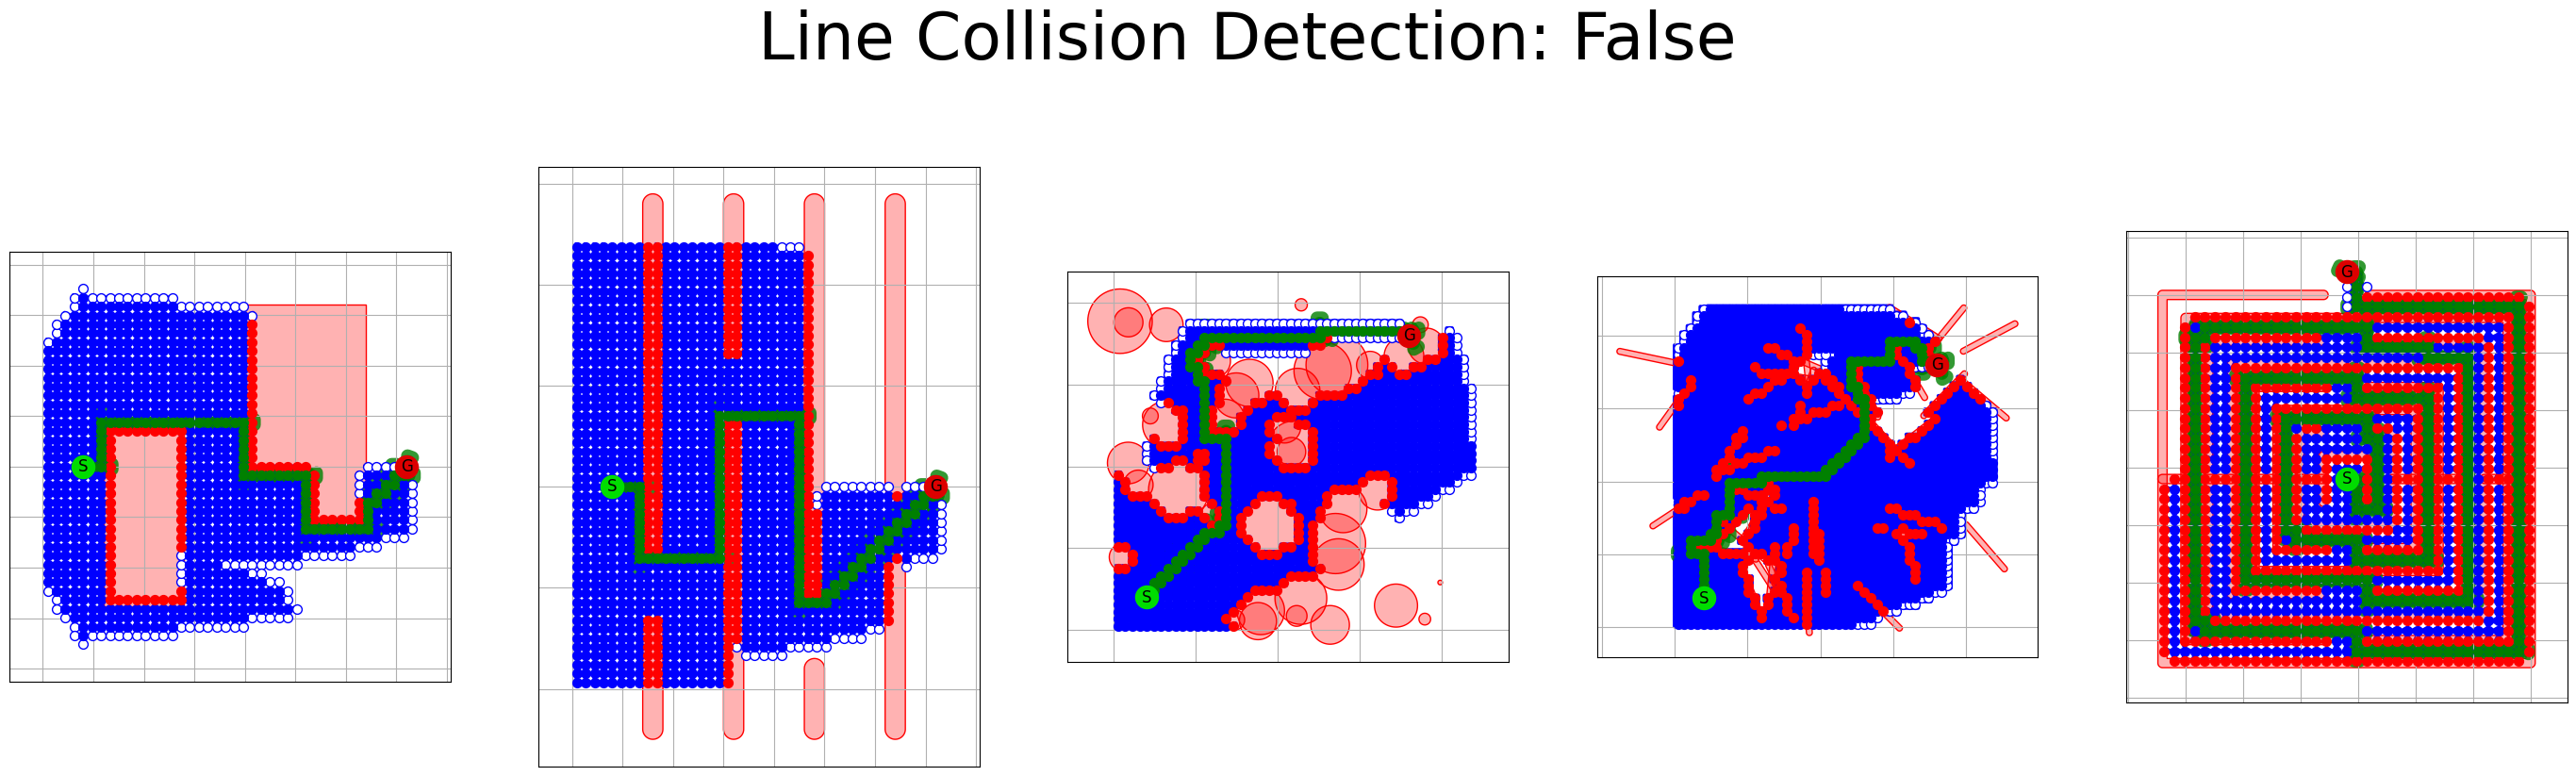

In [14]:
# show results

from IPVISAStar import aStarVisualize

activation_values = [True, False]

for i, (_, config_results) in enumerate(results):
    fig = plt.figure(figsize=(35,10))
    for j, (bench_name, benchmark_results) in enumerate(config_results.items()):
        astar = benchmark_results["astar"]
        solution = benchmark_results["solution"]
        ax = fig.add_subplot(1,len(config_results.items()),j + 1)
        aStarVisualize(planner=astar, solution=solution, ax=ax, nodeSize=(1000 / disc_values[i]), viz_solution=(len(solution) > 0))
    fig.suptitle(f"Line Collision Detection: {activation_values[i]}", fontsize=50)
    plt.show()